**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [81]:
import pandas as pd
import numpy as np
import itertools
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [82]:
# The parameter names must match the pipeline step names, e.g., 'classifier__max_depth'
# ToDo: Define base models (Decision Tree, kNN, Logistic Regression)

dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)

param_grid_dt = {
    "classifier__max_depth": [3, 5, 10, None],
    "classifier__min_samples_split": [2, 5, 10]
}

param_grid_knn = {
    "classifier__n_neighbors": [3, 5, 7, 11],
    "classifier__weights": ["uniform", "distance"]
}

param_grid_lr = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l1", "l2"]
}

# ToDo: Create a list of (classifier, param_grid, name) tuples
classifiers_to_tune = [
    (dt, param_grid_dt, "Decision Tree"),
    (knn, param_grid_knn, "KNN"),
    (lr, param_grid_lr, "Logistic Regression")
]

## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [ ]:
'''def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"'''

### 3.2 HR Attrition Dataset


In [83]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [ ]:
'''def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"'''


### 3.4 QSAR Biodegradation Dataset





In [ ]:
'''def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"'''

## Part 4: Manual Grid Search Implementation



In [84]:
from sklearn.feature_selection import VarianceThreshold
def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # TODO: Implement manual grid search for hyperparameter tuning.
        # Steps to implement:
        # 1. Adjust the feature selection parameter grid to ensure 'k' does not exceed the number of features.
        # 2. Generate all combinations of hyperparameters from the adjusted parameter grid.
        # 3. For each parameter combination:
        #    a. Perform cross-validation (e.g., 5-fold StratifiedKFold).
        #    b. For each fold:
        #       i. Split the training data into training and validation sets.
        #       ii. Build a pipeline with scaling, feature selection, and the classifier.
        #       iii. Set the pipeline parameters for the current combination.
        #       iv. Fit the pipeline on the training fold.
        #       v. Predict probabilities on the validation fold.
        #       vi. Compute the AUC score for the fold.
        #    c. Compute the mean AUC across all folds for the parameter combination.
        #    d. Track and print the best parameter combination and its mean AUC.

        if 'classifier__k' in param_grid:
            param_grid['classifier__k'] = [k for k in param_grid['classifier__k'] if k <= n_features]

        keys, values = zip(*param_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in product(*values)]

        for params in param_combinations:
            auc_scores = []

            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                pipeline = Pipeline(steps=[
                    ('variance_filter', VarianceThreshold()),
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif, k=n_features)),
                    ('classifier', classifier_instance)
                ])

                pipeline.set_params(**params)

                pipeline.fit(X_tr, y_tr)

                y_prob = pipeline.predict_proba(X_val)[:, 1]

                auc_fold = roc_auc_score(y_val, y_prob)
                auc_scores.append(auc_fold)

            mean_auc = np.mean(auc_scores)

            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params


        # Create the final pipeline for this classifier
        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        final_pipeline = Pipeline(steps=[
            ('variance_filter', VarianceThreshold()),
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Set the best parameters found
        final_pipeline.set_params(**best_params)

        # Fit the final pipeline on the full training data
        final_pipeline.fit(X_train, y_train)

        # Store the fully trained best pipeline
        best_estimators[name] = final_pipeline

    return best_estimators

**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [85]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # TODO: Implement built-in grid search for each classifier:
        # - Adjust feature selection parameter grid based on dataset size (n_features)
        # - Create a pipeline with StandardScaler, SelectKBest(f_classif), and the classifier
        # - Set up StratifiedKFold cross-validation
        # - Run GridSearchCV with the pipeline and adjusted param grid
        # - Fit grid search on training data and collect best estimator/results

        # Example code fragments that may be needed:
        # n_features = X_train.shape[1]
        # pipeline = Pipeline(steps=[
        #     ('scaler', StandardScaler()),
        #     ('feature_selection', SelectKBest(f_classif)),
        #     ('classifier', classifier_instance)
        # ])
        # cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        if 'classifier__k' in param_grid:
            param_grid['classifier__k'] = [k for k in param_grid['classifier__k'] if k <= n_features]

        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif, k=n_features)),
            ('classifier', classifier_instance)
        ])

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring='roc_auc',
            cv=cv_splitter,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        # Save results
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin

## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [86]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import VotingClassifier

def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate individual models and visualize performance, including voting classifier"""
    
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # --- Individual Model Performance ---
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # --- Voting Classifier ---
    print(f"\n--- Voting Classifier ({method_name}) ---")

    # Average predicted probabilities across all classifiers
    y_pred_proba_avg = np.mean([model.predict_proba(X_test)[:, 1] for model in best_estimators.values()], axis=0)
    # Majority vote based on average probability
    y_pred_votes = (y_pred_proba_avg >= 0.5).astype(int)

    # Metrics for voting classifier
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"\nVoting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # --- Visualizations ---
    plt.figure(figsize=(12, 5))

    # ROC Curves
    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Voting classifier ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg


## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [87]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_test, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




################################################################################
PROCESSING DATASET: HR ATTRITION
################################################################################
IBM HR Attrition dataset loaded and preprocessed successfully.
Training set shape: (1029, 46)
Testing set shape: (441, 46)
------------------------------

RUNNING MANUAL GRID SEARCH FOR HR ATTRITION
--- Manual Grid Search for Decision Tree ---


c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn

------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 10}
Best cross-validation AUC: 0.6885
--- Manual Grid Search for KNN ---


c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn

------------------------------------------------------------------------------------------
Best parameters for KNN: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance'}
Best cross-validation AUC: 0.7245
--- Manual Grid Search for Logistic Regression ---


c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=46 is greater than n_features=44. All the features will be returned.
  warnings.warn(
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn

------------------------------------------------------------------------------------------
Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Best cross-validation AUC: 0.8328

EVALUATING MANUAL MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8027
  Precision: 0.3182
  Recall: 0.1972
  F1-Score: 0.2435
  ROC AUC: 0.6806

KNN:
  Accuracy: 0.8277
  Precision: 0.4242
  Recall: 0.1972
  F1-Score: 0.2692
  ROC AUC: 0.7340

Logistic Regression:
  Accuracy: 0.8458
  Precision: 0.5600
  Recall: 0.1972
  F1-Score: 0.2917
  ROC AUC: 0.7615

--- Voting Classifier (Manual) ---

Voting Classifier Performance:
  Accuracy: 0.8322, Precision: 0.4545
  Recall: 0.2113, F1: 0.2885, AUC: 0.7501


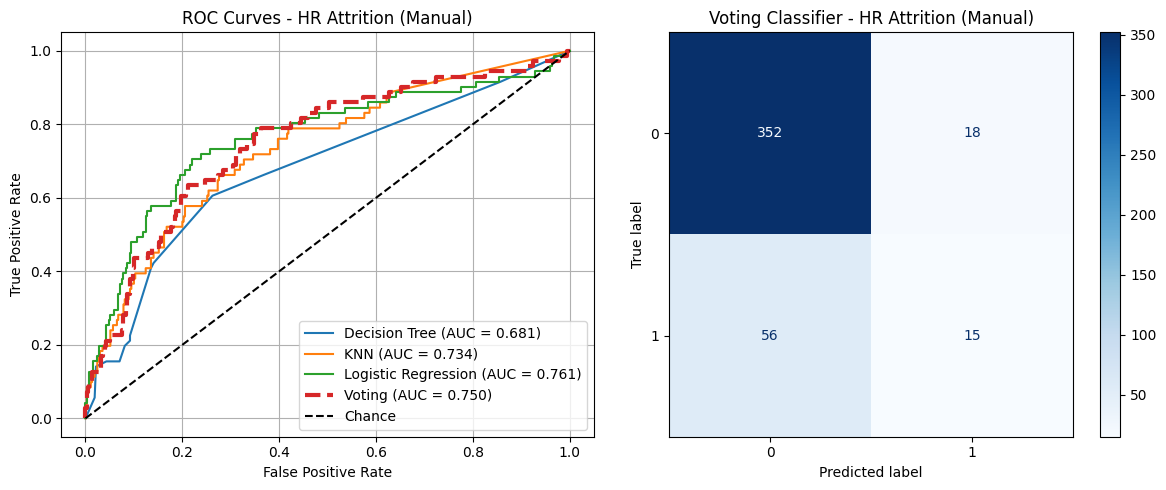


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---


c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
Best CV score: 0.6916

--- GridSearchCV for KNN ---


c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for KNN: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance'}
Best CV score: 0.7245

--- GridSearchCV for Logistic Regression ---


c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Chara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Best CV score: 0.8328

EVALUATING BUILT-IN MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8413
  Precision: 0.5161
  Recall: 0.2254
  F1-Score: 0.3137
  ROC AUC: 0.7165

KNN:
  Accuracy: 0.8413
  Precision: 0.5556
  Recall: 0.0704
  F1-Score: 0.1250
  ROC AUC: 0.6883

Logistic Regression:
  Accuracy: 0.8798
  Precision: 0.7368
  Recall: 0.3944
  F1-Score: 0.5138
  ROC AUC: 0.8177

--- Voting Classifier (Built-in) ---

Voting Classifier Performance:
  Accuracy: 0.8549, Precision: 0.7692
  Recall: 0.1408, F1: 0.2381, AUC: 0.7919


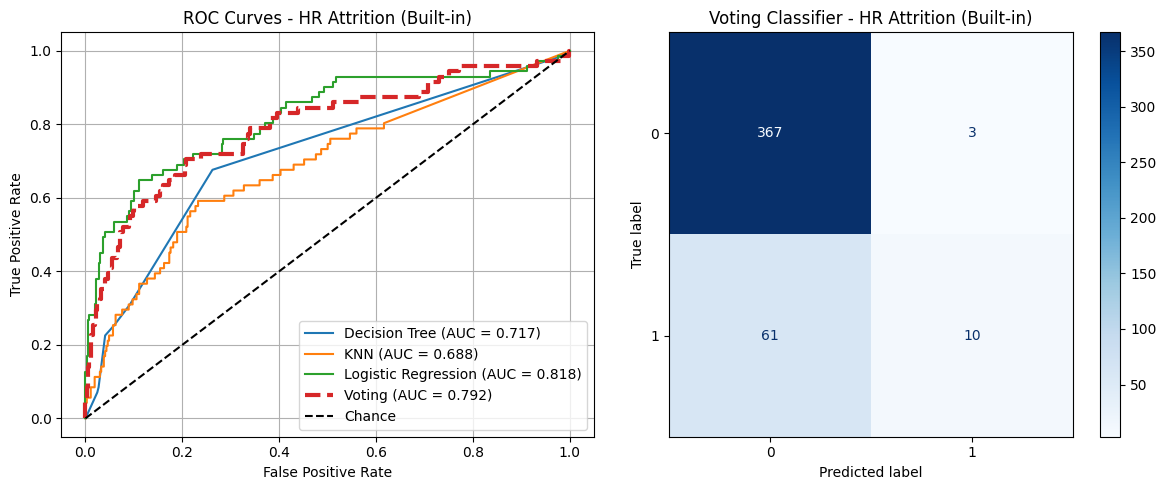


Completed processing for HR Attrition

ALL DATASETS PROCESSED!


In [88]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_hr_attrition, "HR Attrition")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)